<h1>Machine Learning models</h1>

## Imports

In [29]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sampling and scaling 
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Machine learning models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Optimisation
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Reports
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score

# Others
from IPython.display import clear_output
from scipy import stats
import traceback
import re
from pandas import Series

In [2]:
from jupyterthemes import jtplot
jtplot.style(theme = 'onedork')

## Functions

In [3]:
max_bin = 30
force_bin = 3

def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = np.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

def style_stats_specific_cell_IV(x):

    color_thresh = 'background-color: red'
    
    df_color = pd.DataFrame('', index=x.index, columns=x.columns)
    rows_number=len(x.index)
    for r in range(0,rows_number):
        try:
            val=(x.iloc[r, 1])
            if val>0.5:
                df_color.iloc[r, 1] = 'background-color: blue'
            elif val>0.3:
                df_color.iloc[r, 1] = 'background-color: green'
            elif val>0.1:
                df_color.iloc[r, 1] = 'background-color: orange'
            elif val>0.02:
                df_color.iloc[r, 1] = 'background-color: yellow'
            else: 
                df_color.iloc[r, 1] = 'background-color: red'
        except:
            pass
    return df_color

## Reading csv files

In [4]:
Assure = pd.read_csv('../Cleaned_Data/Assure.csv')
BonusMalus = pd.read_csv('../Cleaned_Data/BonusMalus.csv')
Police = pd.read_csv('../Cleaned_Data/Police.csv')
Sinistre = pd.read_csv('../Cleaned_Data/Sinistre.csv')
Vehicule = pd.read_csv('../Cleaned_Data/Vehicule.csv')

## Creating training dataframe
### Features to use in machine learning algorithms
- Police
    - policeId (index)
    - typePolice
    - naturePolice

- Vehicule
    - puissanceFiscale
    - typeImmatriculation
    - energie
    - marque
    - usage

- Assure
    - anneesExp (2020 - Année d'obtention du permis)
    - gouvernorat

- Sinistre
    - nombreDeSinistres

- BonusMalus
    - classeBonusMalus (target)

## $\rightarrow$ train_df ~ Police

In [5]:
train_df = Police.copy()

print(train_df.shape)
print()
train_df.head()

(94620, 8)



,policeId,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation
0,61519,8,19,T,I,2016-04-17,V,0
1,61553,8,90,R,I,2016-04-21,V,0
2,61587,8,71,R,I,2016-04-26,V,0
3,61787,8,13,R,I,2016-05-27,V,0
4,61796,8,36,R,I,2016-05-27,V,0


## $\rightarrow$ train_df ~ BonusMalus

In [6]:
poop = BonusMalus.set_index('policeId')[['vehiculeId', 'assureId', 'classeBonusMalus']]
train_df = train_df.join(poop, on = 'policeId', how = 'left')

print(train_df.shape)
print()
train_df.head()

(94620, 11)



,policeId,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation,vehiculeId,assureId,classeBonusMalus
0,61519,8,19,T,I,2016-04-17,V,0,57288.0,54006.0,3.0
1,61553,8,90,R,I,2016-04-21,V,0,57321.0,54038.0,3.0
2,61587,8,71,R,I,2016-04-26,V,0,57355.0,54071.0,3.0
3,61787,8,13,R,I,2016-05-27,V,0,57553.0,54249.0,2.0
4,61796,8,36,R,I,2016-05-27,V,0,57562.0,54258.0,7.0


## $\rightarrow$ train_df ~ Vehicule

In [7]:
poop = Vehicule.set_index('vehiculeId')
train_df = train_df.join(poop, on = 'vehiculeId', how = 'left').drop(columns = ['vehiculeId'])

print(train_df.shape)
print()
train_df.head()

(94620, 16)



,policeId,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation,assureId,classeBonusMalus,puissanceFiscal,typeImmatriculation,energie,etatVehicule,marque,usage
0,61519,8,19,T,I,2016-04-17,V,0,54006.0,3.0,9.0,TU,GASOIL,V,IVECO,Agricole1 véhicule dont le PTC < 3500 kg
1,61553,8,90,R,I,2016-04-21,V,0,54038.0,3.0,5.0,TU,ESSENCE,V,VOLKSWAGEN,Auto-Ecole
2,61587,8,71,R,I,2016-04-26,V,0,54071.0,3.0,5.0,TU,GASOIL,V,PEUGEOT,Taxi
3,61787,8,13,R,I,2016-05-27,V,0,54249.0,2.0,6.0,TU,ESSENCE,V,MAZDA,Privé et professionnel
4,61796,8,36,R,I,2016-05-27,V,0,54258.0,7.0,5.0,TU,GASOIL,V,CITROEN,Utilitaire 1 véhicule dont le PTC < 3500 kg (y...


## $\rightarrow$ train_df ~ Assure

In [8]:
poop = Assure.set_index('assureId')
train_df = train_df.join(poop, on = 'assureId', how = 'left').drop(columns = ['assureId'])

print(train_df.shape)
print()
train_df.head()

(94620, 18)



,policeId,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation,classeBonusMalus,puissanceFiscal,typeImmatriculation,energie,etatVehicule,marque,usage,codeTypePieceIdentite,gouvernorat,anneesExpConduite
0,61519,8,19,T,I,2016-04-17,V,0,3.0,9.0,TU,GASOIL,V,IVECO,Agricole1 véhicule dont le PTC < 3500 kg,NaN,NaN,NaN
1,61553,8,90,R,I,2016-04-21,V,0,3.0,5.0,TU,ESSENCE,V,VOLKSWAGEN,Auto-Ecole,NaN,NaN,NaN
2,61587,8,71,R,I,2016-04-26,V,0,3.0,5.0,TU,GASOIL,V,PEUGEOT,Taxi,1.0,Tunis,38.0
3,61787,8,13,R,I,2016-05-27,V,0,2.0,6.0,TU,ESSENCE,V,MAZDA,Privé et professionnel,1.0,Tunis,41.0
4,61796,8,36,R,I,2016-05-27,V,0,7.0,5.0,TU,GASOIL,V,CITROEN,Utilitaire 1 véhicule dont le PTC < 3500 kg (y...,NaN,NaN,NaN


## $\rightarrow$ Dropping missing values

In [9]:
train_df.dropna(inplace = True)

print(train_df.shape)
print()
train_df.head()

(34674, 18)



,policeId,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation,classeBonusMalus,puissanceFiscal,typeImmatriculation,energie,etatVehicule,marque,usage,codeTypePieceIdentite,gouvernorat,anneesExpConduite
2,61587,8,71,R,I,2016-04-26,V,0,3.0,5.0,TU,GASOIL,V,PEUGEOT,Taxi,1.0,Tunis,38.0
3,61787,8,13,R,I,2016-05-27,V,0,2.0,6.0,TU,ESSENCE,V,MAZDA,Privé et professionnel,1.0,Tunis,41.0
5,61830,8,71,R,I,2016-06-01,V,0,2.0,5.0,TU,GASOIL,V,SEAT,Taxi,1.0,Ben Arous,38.0
15,62859,8,71,R,I,2016-11-23,V,0,3.0,5.0,TU,ESSENCE,V,RENAULT,Privé et professionnel,1.0,Tunis,20.0
20,63127,8,79,R,I,2016-12-30,V,0,1.0,4.0,TU,ESSENCE,V,HYUNDAI,Privé et professionnel,1.0,Tunis,39.0


## $\rightarrow$ Shifting target variable to the end of the table

In [10]:
tmp = train_df.copy()
tmp.drop(columns = ['classeBonusMalus'], inplace = True)
tmp['classeBonusMalus'] = train_df['classeBonusMalus'].values
train_df = tmp

train_df.head()

,policeId,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation,puissanceFiscal,typeImmatriculation,energie,etatVehicule,marque,usage,codeTypePieceIdentite,gouvernorat,anneesExpConduite,classeBonusMalus
2,61587,8,71,R,I,2016-04-26,V,0,5.0,TU,GASOIL,V,PEUGEOT,Taxi,1.0,Tunis,38.0,3.0
3,61787,8,13,R,I,2016-05-27,V,0,6.0,TU,ESSENCE,V,MAZDA,Privé et professionnel,1.0,Tunis,41.0,2.0
5,61830,8,71,R,I,2016-06-01,V,0,5.0,TU,GASOIL,V,SEAT,Taxi,1.0,Ben Arous,38.0,2.0
15,62859,8,71,R,I,2016-11-23,V,0,5.0,TU,ESSENCE,V,RENAULT,Privé et professionnel,1.0,Tunis,20.0,3.0
20,63127,8,79,R,I,2016-12-30,V,0,4.0,TU,ESSENCE,V,HYUNDAI,Privé et professionnel,1.0,Tunis,39.0,1.0


## $\rightarrow$ Setting policeId as index

In [11]:
train_df.set_index('policeId', inplace = True)

## $\rightarrow$ Creating new target variables 
- 2 Classes :
    - 1 $\rightarrow$ 7 : Good (1)
    - 8 $\rightarrow$ 11 : Bad (0)
- 3 Classes :
    - 1 $\rightarrow$ 4 : Good (2)
    - 5 $\rightarrow$ 8 : Average (1)
    - 8 $\rightarrow$ 11 : Bad (0)

In [12]:
classes = train_df['classeBonusMalus'].values
classes3 = []
classes2 = []

for i in range(len(classes)):
    if classes[i] < 5:
        classes3.append(2)
    elif classes[i] < 8:
        classes3.append(1)
    else:
        classes3.append(0)

for i in range(len(classes)):
    if classes[i] < 8:
        classes2.append(1)
    else:
        classes2.append(0)

train_df['2Classes'] = classes2
train_df['3Classes'] = classes3
train_df.drop(columns = ['classeBonusMalus'], inplace = True)

train_df.head()

,codeCompagnie,codeAgence,naturePolice,typePolice,dateEffetPolice,etatPolice,resiliation,puissanceFiscal,typeImmatriculation,energie,etatVehicule,marque,usage,codeTypePieceIdentite,gouvernorat,anneesExpConduite,2Classes,3Classes
policeId,,,,,,,,,,,,,,,,,,
61587,8,71,R,I,2016-04-26,V,0,5.0,TU,GASOIL,V,PEUGEOT,Taxi,1.0,Tunis,38.0,1,2
61787,8,13,R,I,2016-05-27,V,0,6.0,TU,ESSENCE,V,MAZDA,Privé et professionnel,1.0,Tunis,41.0,1,2
61830,8,71,R,I,2016-06-01,V,0,5.0,TU,GASOIL,V,SEAT,Taxi,1.0,Ben Arous,38.0,1,2
62859,8,71,R,I,2016-11-23,V,0,5.0,TU,ESSENCE,V,RENAULT,Privé et professionnel,1.0,Tunis,20.0,1,2
63127,8,79,R,I,2016-12-30,V,0,4.0,TU,ESSENCE,V,HYUNDAI,Privé et professionnel,1.0,Tunis,39.0,1,2


## $\rightarrow$ Splitting dataframes :
- train_df2 : Training dataframe with `2Classes` as target variable
- train_df3 : Training dataframe with `3Classes` as target variable

In [13]:
train_df2 = train_df.iloc[:, :-1]
train_df3 = train_df.drop(columns = ['2Classes'])

## $\rightarrow$ Calculating information value
### 2 Classes

In [14]:
final_iv, IV = data_vars(train_df2, train_df2['2Classes'])
display(IV.sort_values('IV', ascending = False).style.apply(style_stats_specific_cell_IV, axis = None))

C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,VAR_NAME,IV
4,dateEffetPolice,0.857957
15,usage,0.436131
0,anneesExpConduite,0.282763
9,marque,0.257265
2,codeCompagnie,0.217801
5,energie,0.207837
6,etatPolice,0.115124
8,gouvernorat,0.084904
11,puissanceFiscal,0.077537
12,resiliation,0.054622


### 3 Classes

In [15]:
final_iv, IV = data_vars(train_df3, train_df3['3Classes'])
display(IV.sort_values('IV', ascending = False).style.apply(style_stats_specific_cell_IV, axis = None))

C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,VAR_NAME,IV
4,dateEffetPolice,0.041576
0,anneesExpConduite,0.012295
6,etatPolice,0.003596
12,resiliation,0.002480
15,usage,0.002037
9,marque,0.001381
8,gouvernorat,0.001106
1,codeAgence,0.001010
5,energie,0.000360
13,typeImmatriculation,0.000092


## Our data describes best the target value with only 2 classes
## $\Rightarrow$ Columns to use :
- usage
- anneesExpConduite
- marque
- codeCompagnie
- energie
- gouvernorat
- puissanceFiscal
- nombreDeSinistres

## $\rightarrow$ Dropping useless columns

In [16]:
train_df2.drop(columns = ['dateEffetPolice', 'etatPolice', 'resiliation', 'typeImmatriculation',
                          'codeAgence', 'naturePolice', 'etatVehicule', 'codeTypePieceIdentite', 
                          'typePolice'], inplace = True)

train_df2.head()

,codeCompagnie,puissanceFiscal,energie,marque,usage,gouvernorat,anneesExpConduite,2Classes
policeId,,,,,,,,
61587,8,5.0,GASOIL,PEUGEOT,Taxi,Tunis,38.0,1
61787,8,6.0,ESSENCE,MAZDA,Privé et professionnel,Tunis,41.0,1
61830,8,5.0,GASOIL,SEAT,Taxi,Ben Arous,38.0,1
62859,8,5.0,ESSENCE,RENAULT,Privé et professionnel,Tunis,20.0,1
63127,8,4.0,ESSENCE,HYUNDAI,Privé et professionnel,Tunis,39.0,1


In [17]:
train_df2[train_df2['2Classes'] == 0]

,codeCompagnie,puissanceFiscal,energie,marque,usage,gouvernorat,anneesExpConduite,2Classes
policeId,,,,,,,,
65847,6,5.0,ESSENCE,VOLKSWAGEN,Privé et professionnel,Tunis,28.0,0
289411,15,4.0,ESSENCE,FIAT,Privé et professionnel,Sfax,14.0,0
289479,15,4.0,ESSENCE,HYUNDAI,Privé et professionnel,Tunis,11.0,0
65755,6,11.0,GASOIL,KIA,Privé et professionnel,Ben Arous,20.0,0
65735,6,6.0,GASOIL,VOLKSWAGEN,Privé et professionnel,Ben Arous,35.0,0
...,...,...,...,...,...,...,...,...
2795907,6,4.0,ESSENCE,KIA,Privé et professionnel,Nabeul,34.0,0
2796021,6,4.0,ESSENCE,RENAULT,Privé et professionnel,Sfax,5.0,0
2796850,6,7.0,ESSENCE,RENAULT,Privé et professionnel,Sousse,33.0,0


In [18]:
train_df2.to_csv('../Clean Data/train_df.csv')

## $\rightarrow$ Target variable distribution

Text(0.5, 1.0, 'Distribution of Target Variable\n')

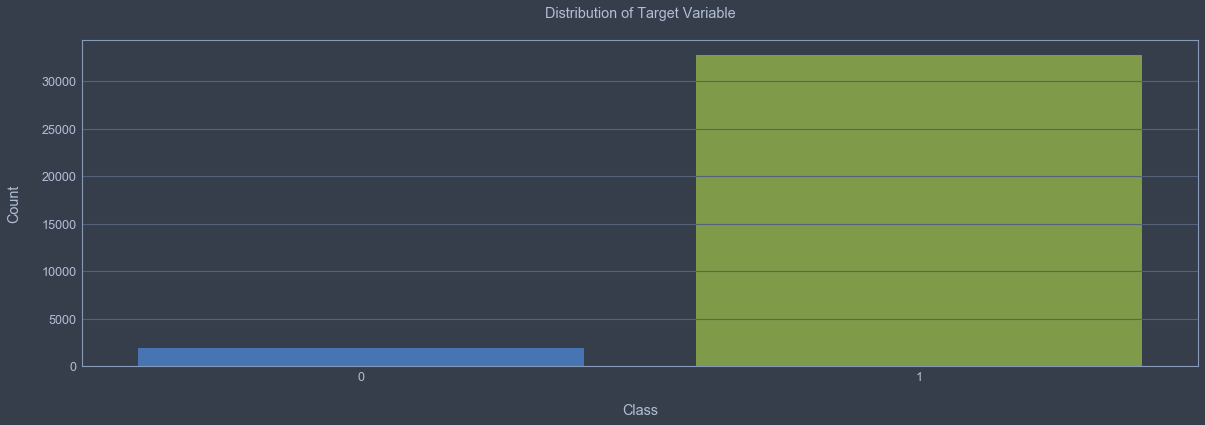

In [19]:
plt.figure(figsize = (20, 6))
sns.countplot(data = train_df2, x = '2Classes');
plt.xlabel('\nClass')
plt.ylabel('Count\n')
plt.title('Distribution of Target Variable\n')

## $\rightarrow$ Encoding categorical variables and creating Dummy Variables

In [20]:
train_df2.head()

,codeCompagnie,puissanceFiscal,energie,marque,usage,gouvernorat,anneesExpConduite,2Classes
policeId,,,,,,,,
61587,8,5.0,GASOIL,PEUGEOT,Taxi,Tunis,38.0,1
61787,8,6.0,ESSENCE,MAZDA,Privé et professionnel,Tunis,41.0,1
61830,8,5.0,GASOIL,SEAT,Taxi,Ben Arous,38.0,1
62859,8,5.0,ESSENCE,RENAULT,Privé et professionnel,Tunis,20.0,1
63127,8,4.0,ESSENCE,HYUNDAI,Privé et professionnel,Tunis,39.0,1


In [21]:
train_df2['codeCompagnie'] = train_df2['codeCompagnie'].astype(str)
categ = ['codeCompagnie','energie', 'marque', 'usage', 'gouvernorat']

tmp = pd.get_dummies(train_df2[categ])

#tmp['nombreDeSinistres'] = train_df2['nombreDeSinistres'].values
tmp['puissanceFiscal'] = train_df2['puissanceFiscal'].values
tmp['anneesExpConduite'] = train_df2['anneesExpConduite'].values
tmp['2Classes'] = train_df2['2Classes'].values

train_df2 = tmp

train_df2.head()

,codeCompagnie_1,codeCompagnie_11,codeCompagnie_13,codeCompagnie_15,codeCompagnie_2,codeCompagnie_3,codeCompagnie_4,codeCompagnie_5,codeCompagnie_6,codeCompagnie_7,...,gouvernorat_Sidi Bouzid,gouvernorat_Siliana,gouvernorat_Sousse,gouvernorat_Tataouine,gouvernorat_Tozeur,gouvernorat_Tunis,gouvernorat_Zaghouan,puissanceFiscal,anneesExpConduite,2Classes
policeId,,,,,,,,,,,,,,,,,,,,,
61587,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,5.0,38.0,1
61787,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,6.0,41.0,1
61830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5.0,38.0,1
62859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,5.0,20.0,1
63127,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,4.0,39.0,1


## $\rightarrow$ Resampling target variable (Down-sampling majority class)

Text(0.5, 1.0, 'Distribution of Target Variable (After Down-Sampling)\n')

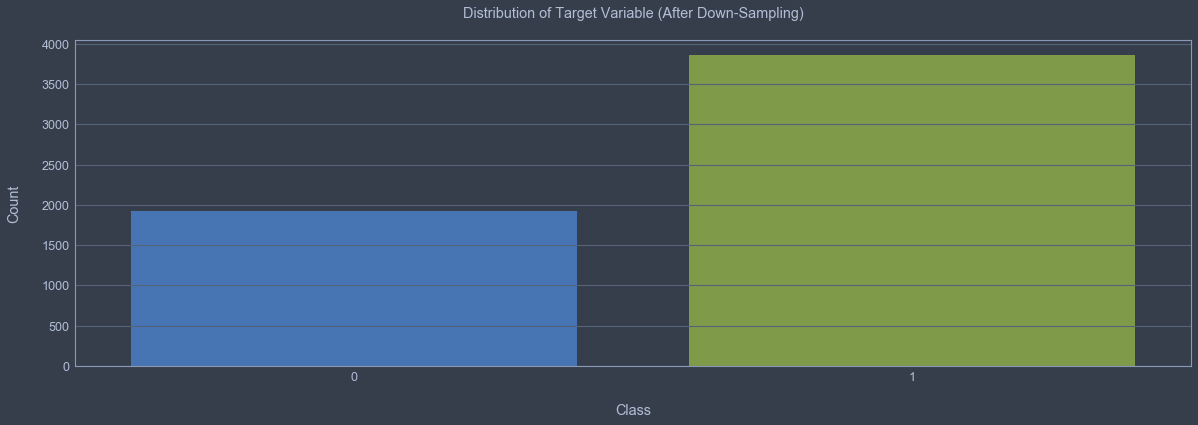

In [22]:
df_majority = train_df2[train_df2['2Classes'] == 1]
df_minority = train_df2[train_df2['2Classes'] == 0]

n_samples = (train_df2['2Classes'].value_counts().values[1])*(2)

majority_resamp_df = resample(df_majority, replace = False, n_samples = int(n_samples), random_state = 0)
resamp_df = pd.concat([majority_resamp_df, df_minority])

plt.figure(figsize = (20, 6))
sns.countplot(data = resamp_df, x = '2Classes');
plt.xlabel('\nClass')
plt.ylabel('Count\n')
plt.title('Distribution of Target Variable (After Down-Sampling)\n')

## $\rightarrow$ Oversampling data to reach balance

Text(0.5, 1.0, 'Distribution of Target Variable (After Over-Sampling)\n')

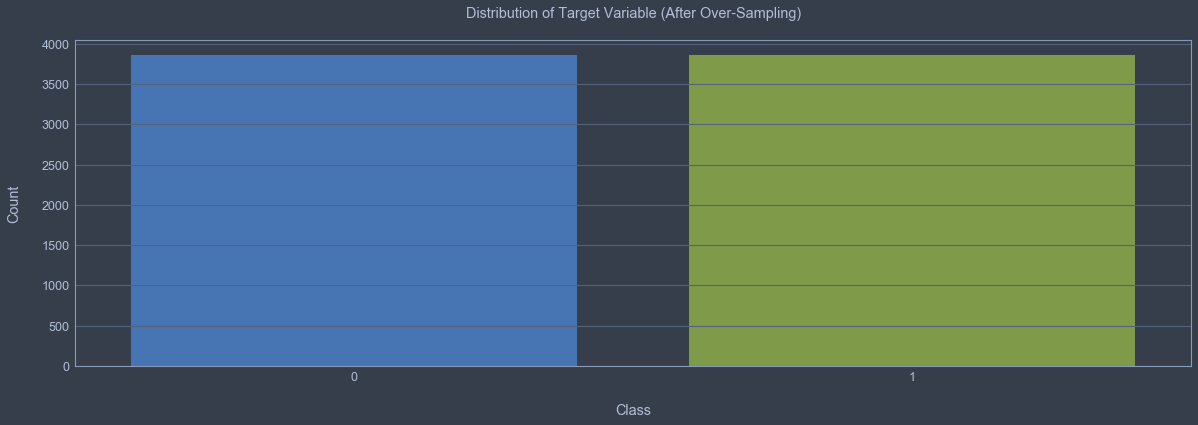

In [23]:
X = resamp_df.iloc[:, :-1].values
y = resamp_df.iloc[:, -1].values

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

plt.figure(figsize = (20, 6))
sns.countplot(x = y);
plt.xlabel('\nClass')
plt.ylabel('Count\n')
plt.title('Distribution of Target Variable (After Over-Sampling)\n')

## $\rightarrow$ Splitting train and test data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## $\rightarrow$ Scaling data

In [25]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

<center>
    <hr>
    <h1>Machine Learning algorithms</h1>
    <hr>
</center>

## $\rightarrow$ K-Nearest Neighbors

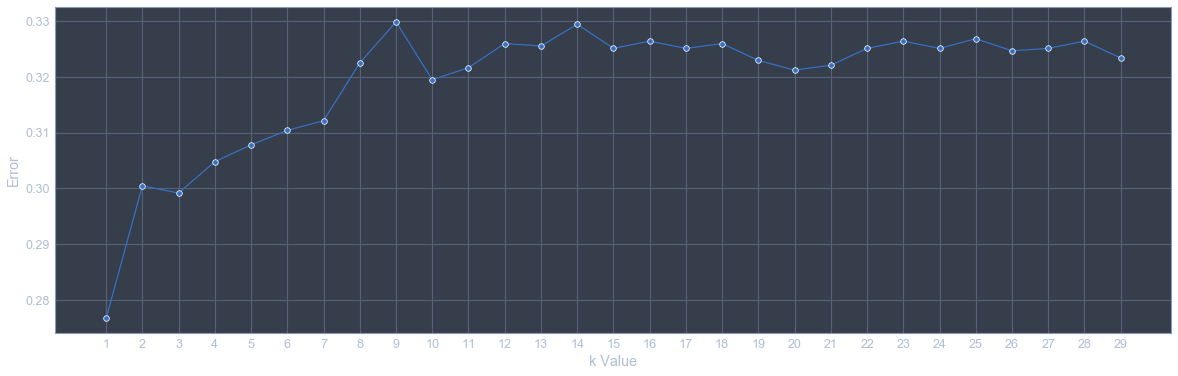

In [35]:
error = []

for i in range(1, 30):
    classifier = KNeighborsClassifier(n_neighbors = i)
    classifier.fit(X_train, y_train)
    yi_pred = classifier.predict(X_test)
    error.append(np.mean(yi_pred != y_test))
    print('Loop ' + str(i))
    clear_output(wait = True)

plt.figure(figsize = (20, 6))
plt.xticks(range(1, 30, 1))
plt.xlabel("k Value")
plt.ylabel("Error")
sns.lineplot(range(1, 30), error, marker = 'o');

A 1-NN model is unstable and sensitive to noise. We move on to other models

In [26]:
classifier = KNeighborsClassifier(n_neighbors = 1)
classifier.fit(X_train, y_train)
y_pred_knn = classifier.predict(X_test)

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.71      0.76      0.74      1150
           1       0.75      0.70      0.72      1163

    accuracy                           0.73      2313
   macro avg       0.73      0.73      0.73      2313
weighted avg       0.73      0.73      0.73      2313



## $\rightarrow$ SVM

In [29]:
Cs = [0.01, 0.1, 1]
gammas = [0.01, 0.1, 1]
kernels = ['rbf', 'linear']
param_grid = {'C': Cs, 
              'gamma' : gammas, 
              'kernel': kernels}

grid_search = GridSearchCV(SVC(), param_grid, cv = 5)
grid_search.fit(X_train, y_train)

print(grid_search.best_estimator_)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [27]:
classifier = SVC(C = 1, break_ties = False, cache_size = 200, class_weight = None, 
                 coef0 = 0.0, decision_function_shape = 'ovr', degree = 3, gamma = 0.1, 
                 kernel = 'rbf', max_iter = -1, probability = False, random_state = None, 
                 shrinking = True, tol = 0.001, verbose = False)

model = classifier.fit(X_train, y_train)
y_pred_svc = classifier.predict(X_test)

print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.69      0.89      0.77      1150
           1       0.84      0.60      0.70      1163

    accuracy                           0.74      2313
   macro avg       0.77      0.74      0.74      2313
weighted avg       0.77      0.74      0.74      2313



## $\rightarrow$ Random Forest

In [25]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

classifier = RandomForestClassifier()
random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, 
                            n_iter = 5, cv = 3, random_state = 42, n_jobs = -1)

random.fit(X_train, y_train)

print(random.best_params_)

{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}


In [28]:
classifier = RandomForestClassifier(n_estimators = 200, max_features = 'sqrt', 
                                    max_depth = 50, min_samples_split = 10, 
                                    min_samples_leaf = 2, bootstrap = True)
classifier.fit(X_train, y_train)
y_pred_rand = classifier.predict(X_test)

print(classification_report(y_test, y_pred_rand))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1150
           1       0.84      0.69      0.76      1163

    accuracy                           0.78      2313
   macro avg       0.79      0.78      0.78      2313
weighted avg       0.79      0.78      0.78      2313



## $\rightarrow$ Naïve Bayes

In [30]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred_nb = classifier.predict(X_test)

print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.58      0.99      0.73      1150
           1       0.97      0.30      0.46      1163

    accuracy                           0.64      2313
   macro avg       0.78      0.65      0.60      2313
weighted avg       0.78      0.64      0.60      2313



## $\rightarrow$ Logistic Regression

In [34]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred_logreg = classifier.predict(X_test)

print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.68      0.84      0.75      1150
           1       0.79      0.60      0.69      1163

    accuracy                           0.72      2313
   macro avg       0.73      0.72      0.72      2313
weighted avg       0.73      0.72      0.72      2313



In [35]:
print('Naïve Bayes Report\n')
print(classification_report(y_test, y_pred_nb))
print('Logistic Regression Report\n')
print(classification_report(y_test, y_pred_logreg))
print('SVM Classification Report\n')
print(classification_report(y_test, y_pred_svc))
print('Random Forest Classification Report\n')
print(classification_report(y_test, y_pred_rand))

Naïve Bayes Report

              precision    recall  f1-score   support

           0       0.58      0.99      0.73      1150
           1       0.97      0.30      0.46      1163

    accuracy                           0.64      2313
   macro avg       0.78      0.65      0.60      2313
weighted avg       0.78      0.64      0.60      2313

Logistic Regression Report

              precision    recall  f1-score   support

           0       0.68      0.84      0.75      1150
           1       0.79      0.60      0.69      1163

    accuracy                           0.72      2313
   macro avg       0.73      0.72      0.72      2313
weighted avg       0.73      0.72      0.72      2313

SVM Classification Report

              precision    recall  f1-score   support

           0       0.69      0.89      0.77      1150
           1       0.84      0.60      0.70      1163

    accuracy                           0.74      2313
   macro avg       0.77      0.74      0.74      2313

In [59]:
prec0_svc = precision_score(y_test, y_pred_svc, average = None)[0]
prec1_svc = precision_score(y_test, y_pred_svc, average = None)[1]
prec0_rand = precision_score(y_test, y_pred_rand, average = None)[0]
prec1_rand = precision_score(y_test, y_pred_rand, average = None)[1]

df = pd.DataFrame({
    'Class': ['0', '1']*2,
    'Score': [prec0_svc, prec1_svc, prec0_rand, prec1_rand],
    'Model': ['SVM', 'SVM', 'Random Forest', 'Random Forest']
})

%matplotlib qt
sns.barplot(data = df, x = 'Class', y = 'Score', hue = 'Model');
plt.yticks(np.arange(0, 1.1, 0.1));
plt.xlabel('\nClass')
plt.ylabel('Precision\n')

Text(0, 0.5, 'Precision\n')